# Experiment: Retrieval and Analysis of ASCAT and ISMN Data for Soil Moisture Estimation

## Introduction
This experiment focuses on retrieving and analyzing satellite-based ASCAT data and in-situ ISMN data for soil moisture estimation. The objective is to explore the spatiotemporal dynamics of soil moisture by leveraging the H-SAF ASCAT SSM CDR and ISMN data. Additionally, the experiment includes the calculation of Vegetation Optical Depth (VOD) to enhance the analysis. The findings from this experiment contribute to a better understanding of soil moisture dynamics and their implications for agriculture, hydrology, and climate modeling.

## Data Preparation
First, we import the necessary packages for data processing and visualization (the initial warnings can be ignored):

In [3]:
import os, glob, sys #Miscellaneous operating system interfaces
import pandas as pd #Python data analysis library for working with data frames and basic analysis
import numpy as np
import ascat.h_saf as hsaf #Package for reading hsaf data
import matplotlib.pyplot as plt #Plotting library
from ismn.interface import ISMN_Interface #Package for reading ISMN data
import pytesmo.temporal_matching as tmatch #Package for temporal matching of two time series
import pytesmo.time_series.anomaly as ts_anom # Package for time series analysis and validation

## Set paths for data
Here we need to set the paths to where the data is stored. Adapt this depending what data you are using, reduced or not, and where they are located. Basic data validation is also included.

In [4]:
workspace_path = os.getcwd()
path_test_data = os.path.join(workspace_path, "ascat_data")
output_path = os.path.join(workspace_path, "output")

print(os.path.isdir(path_test_data))
print(os.path.isdir(workspace_path)) 

h120_path = os.path.join(path_test_data, 'hsaf_reduced')
static_layer_path = os.path.join(path_test_data, 'static_layer')
grid_path = os.path.join(path_test_data,'warp5_grid')

ismn_path = os.path.join(workspace_path,'ismn_data')

True
True


## Read ISMN Data

To read ISMN data there is a package available on github, which is already installed here. A description and examples can be found here: https://ismn.readthedocs.io/en/latest/examples/interface.html
We extract the required data by specifying the network, station, variable, and depth. This is specified by the data included in the metadata and zip. This can also be changed to your desired location, make sure that the cells that are included in the reduced ASCAT dataset, further below, match with the station though.

Found existing ismn metadata in d:\university_stuff\data_science\Semester3\DS\retrieval_analysis_ascat_ismn_ssm\ismn_data\python_metadata\Data_separate_files_header_20101213_20200210_10133_B2yj_20230329.csv.
Network: [Stations]
 COSMOS: ['Rietholzbach']
Location number of the soil moisture data: [0]
                     soil_moisture soil_moisture_flag soil_moisture_orig_flag
date_time                                                                    
2010-12-13 17:00:00          0.074                  G                       M
2010-12-13 18:00:00          0.074                  G                       M
2010-12-13 19:00:00          0.072                  G                       M
2010-12-13 20:00:00          0.072                  G                       M
2010-12-13 21:00:00          0.068                  G                       M


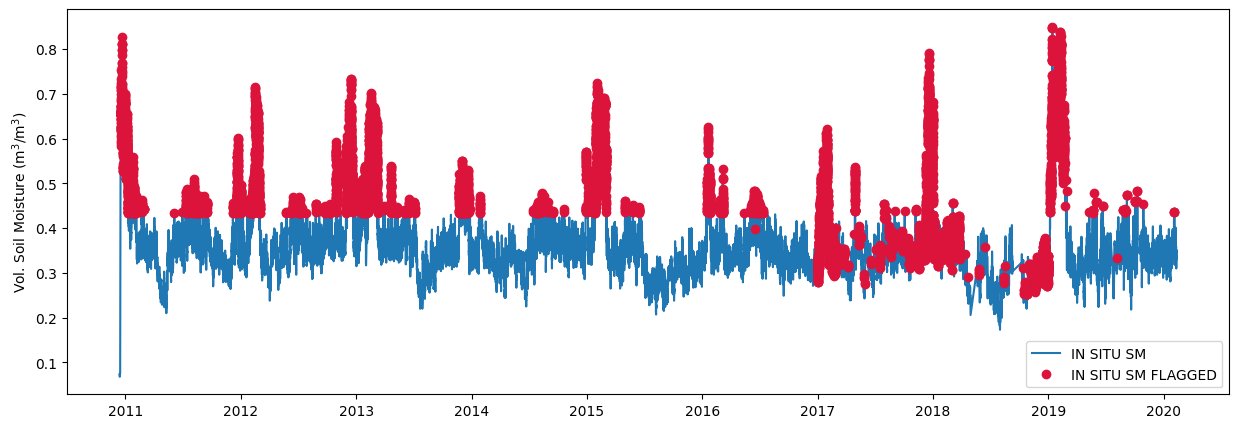

lon: 8.99340, lat: 47.38050


In [5]:
# unzip the ISMN data and metadata
ismn_zipfile = glob.glob(os.path.join(ismn_path, '*.zip'))[0]
ismn_data = ISMN_Interface(ismn_zipfile)

# Check the available data
print('Network: [Stations]\n', ismn_data.collection)

# Get the location id for the specific network, station, variable, and depth
ids = ismn_data.get_dataset_ids(variable='soil_moisture')
print('Location number of the soil moisture data:', ids)

# Read the top soil moisture sensor data
insitu_ts, meta = ismn_data.read(ids[0], return_meta=True)

# Print first five rows of the data and the metadata
print(insitu_ts.head(5))

# Plot the time series of in-situ soil moisture
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(insitu_ts.loc[:, 'soil_moisture'], label='IN SITU SM')
ax.plot(insitu_ts.loc[insitu_ts['soil_moisture_flag'] != 'G', 'soil_moisture'], marker='o', c='crimson', lw=0, label='IN SITU SM FLAGGED')
ax.set_ylabel(r'Vol. Soil Moisture (m$^3$/m$^3$)')
ax.legend()
plt.show()

# Get the longitude and latitude for our station
lon, lat = meta['longitude', 'val'], meta['latitude', 'val']
print('lon: {:.5f}, lat: {:.5f}'.format(lon, lat))


# Read H120 - Metop ASCAT SSM CDR 12.5 km sampling
We need to initialize the reader, where we need to set the paths of the data, the grid file, and the static layers.

Then the data can be read using either longitude and latitude or per grid point.

The `hsaf` package automatically reads the data as a pandas dataframe. Now you can use the full functionality of pandas to do a first analysis of your dataset. 
You can have a quick look at the data by using the `.head()` function, showing you the data structure. For the meaning of the different columns, have a look at the products that can be found here: https://hsaf.meteoam.it/Products/ProductsList?type=soil_moisture

Do note that these columns name follow the standard naming for data like this, and should be straight forward on their own (i.e. *sm* being soil moisture). Most important for getting to know the dataset are the columns 'sm'. 

In [6]:
h120_reader = hsaf.AscatSsmDataRecord(h120_path, grid_path=grid_path, static_layer_path=static_layer_path)

h120_ts=h120_reader.read(lon, lat)
print(lon, lat)
h120_ts.head()

8.9934 47.3805


,sm,sm_noise,dir,ssf,sat_id,proc_flag,corr_flag,conf_flag,slope40,slope40_noise,curvature40,curvature40_noise,sigma40,sigma40_noise,snow_prob,frozen_prob,abs_sm_gldas,abs_sm_noise_gldas,abs_sm_hwsd,abs_sm_noise_hwsd
2007-01-03 08:58:03.750017,69.290001,3.46,1,1,3,0,0,0,-0.100933,0.000954,-0.000302,0.00011,-8.356000,0.100,0,43,NaN,NaN,NaN,NaN
2007-01-05 09:56:48.749002,79.129997,3.38,1,1,3,0,0,0,-0.101463,0.000956,-0.000270,0.00011,-8.075001,0.099,0,57,NaN,NaN,NaN,NaN
2007-01-06 21:01:41.249984,72.360001,3.48,0,1,3,0,0,0,-0.101777,0.000955,-0.000250,0.00011,-8.286000,0.102,0,54,NaN,NaN,NaN,NaN
2007-01-07 20:40:52.499002,72.389999,3.37,0,1,3,0,0,0,-0.102050,0.000955,-0.000230,0.00011,-8.293000,0.099,0,54,NaN,NaN,NaN,NaN
2007-01-08 08:54:41.250009,64.019997,3.43,1,1,3,0,0,0,-0.102331,0.000955,-0.000210,0.00011,-8.554001,0.101,0,29,NaN,NaN,NaN,NaN


## Plot H120 Soil Moisture data
Now that we have loaded the data we can have a first look at the time series. Soil moisture is available as percentage saturation. If you wish to calculate absolute soil moisture values, a possibility is to multiply the soil moisture data with the porosity value which is stored. 

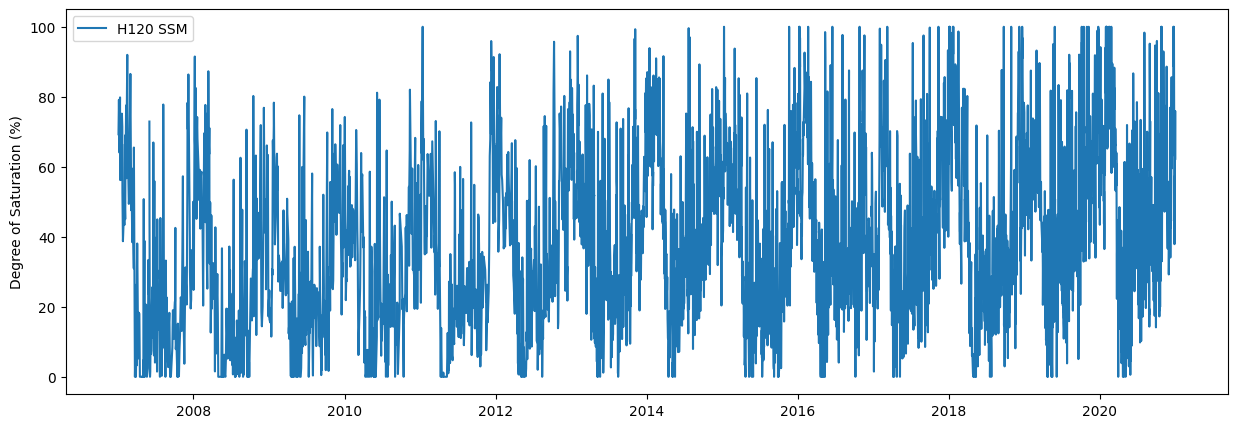

In [7]:
# show complete time series
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ts['sm'], label='H120 SSM')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()
plt.show()

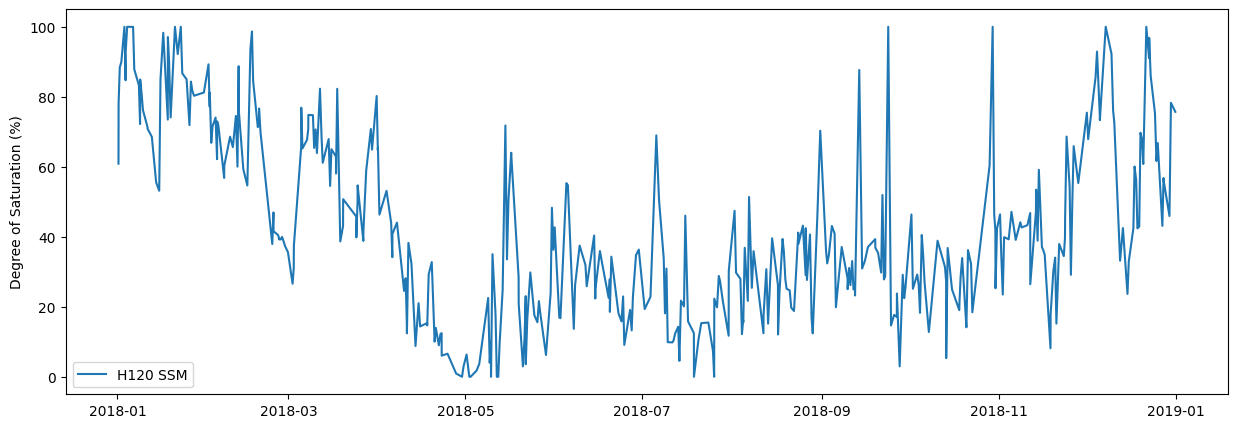

In [8]:
# show time series subset
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ts.loc['2018', 'sm'],  label='H120 SSM')
ax.set_ylabel('Degree of Saturation (%)')
ax.legend()
plt.show()

Soil moisture is affected by snow cover and frozen soils. We can see this in the subset of 2018, where a clear drop in soil moisture is visible in March, which is not likely due to changes in soil moisture. 
Hence we mask for frozen soils and snow cover using the probability mask. Please note, this is not the same as masking using in situ data or model data, but only a probability of that these conditions occur.

## Calculate VOD and Temporal Matching
Now, we will calculate the Vegetation Optical Depth (VOD) using Metop ASCAT observables and perform temporal matching between in situ and satellite observations. The goal is to have a consistent dataset for further analysis.

First, we convert the backscatter values to the dry reference cross-over angle of 25 degrees and calculate the lowest backscatter value:

In [9]:
sig25 = h120_ts.sigma40 + h120_ts.slope40 * (25 - 40) + 0.5 * h120_ts.curvature40 * (25 - 40) ** 2.
dry_25 = np.percentile(sig25, 5)

Next, we convert the backscatter values to the reference angle of 40 degrees and calculate the wet reference value:

In [10]:
dry_ref = dry_25 - h120_ts.slope40 * (25 - 40) - 0.5 * h120_ts.curvature40 * (25 - 40) ** 2
wet_ref = np.percentile(h120_ts.sigma40, 95)

We then set the bare soil sensitivity and convert the reference values to the linear domain. Then, we calculate the total backscatter sensitivity and the inclination angle.
Using these e values, we calculate the VOD as the ratio between the bare soil sensitivity and the total backscatter sensitivity, and store it in the h120 dataframe. Additionally we visualize the time series of VOD for the year 2018, which you can change as desired.

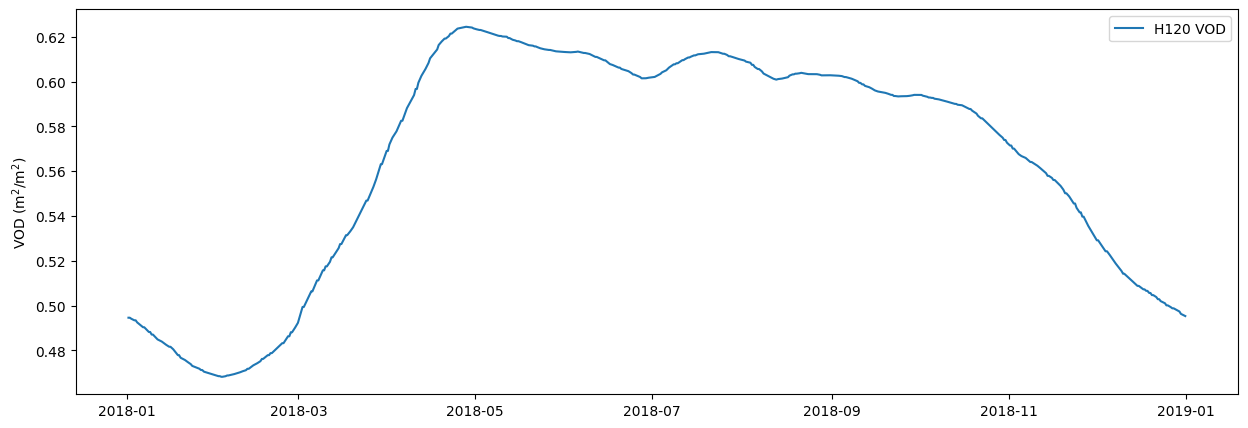

In [11]:
#set bare soil sensitivity
lin_bs_sens=0.21
# convert to linear domain
lin_wet_ref = 10**(wet_ref / 10.)
lin_dry_ref = 10**(dry_ref / 10.)
# get total backscatter sensitivity
lin_sens = lin_wet_ref - lin_dry_ref
inc_angle = -np.cos(np.radians(40)) / 2.
# calculate vod as ratio between bare soil sensitivity and total backscatter sensitivity
# and store it in the h120 dataframe
h120_ts.loc[:, 'vod'] = inc_angle * np.log(lin_sens / lin_bs_sens)
# show time series of VOD 
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(h120_ts.loc['2018', 'vod'],  label='H120 VOD')
ax.set_ylabel(r'VOD (m$^2$/m$^2$)')
ax.legend()
plt.show()

### Temporal matching
Next, we perform temporal matching between the in situ and satellite datasets to find the closest in situ observation to each satellite observation. We set a window of 1 day as the maximum distance between the observations.
To ensure data quality, we can use the provided flags from the in situ and satellite datasets to mask our data for outliers, frozen soils, and snow cover.

In [12]:
insitu_match = tmatch.df_match(h120_ts, insitu_ts, window=1)
df = h120_ts.join(insitu_match)

df_masked = df.loc[df['soil_moisture_flag']=='G',:]
mask = (df_masked['frozen_prob'] > 0) | (df_masked['snow_prob'] > 0)
df_masked = df_masked.mask(mask)

We can create a visualization to compare the masked in situ and ASCAT soil moisture data. Additionally we are saving it for future reuse if necessary.

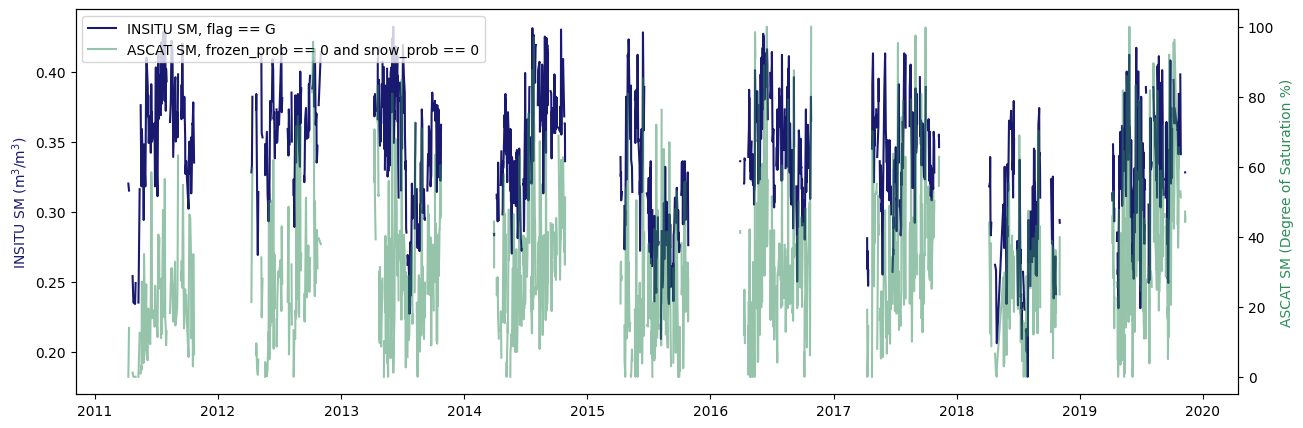

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax2=ax.twinx()
lns1=ax.plot(df_masked[['soil_moisture']],label='INSITU SM, flag == G', c='midnightblue')
lns2=ax2.plot(df_masked['sm'], color='seagreen', label='ASCAT SM, frozen_prob == 0 and snow_prob == 0', alpha=0.5)
ax2.set_ylabel('ASCAT SM (Degree of Saturation %)', c='seagreen')
ax.set_ylabel(r'INSITU SM (m$^3$/m$^3$)', c='midnightblue')
lns = lns1+lns2 # this is to combine the legends from the two axes
labs = [l.get_label() for l in lns] # this is to combine the legends from the two axes
ax.legend(lns, labs, loc=2)

plt.savefig(os.path.join(output_path, 'matched_insitu_ascat.png'))

To complete this experiment, we save our matched dataframe (see below) so we have it ready for further analysis.

In [14]:
df_masked.to_csv(os.path.join(output_path, 'matched_df.csv'))